<a href="https://colab.research.google.com/github/Lilly-jhr/HouseRentPrediction/blob/main/HousePriceRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 1. Data Loading and Exploration
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/usa_housing_dataset.csv")
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-09 00:00:00,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA


 Exploratory Data Analysis (EDA)

In [4]:
df.shape

(4140, 18)

In [5]:
df.isnull().sum()

,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0
condition,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4140 entries, 0 to 4139
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4140 non-null   object 
 1   price          4140 non-null   float64
 2   bedrooms       4140 non-null   float64
 3   bathrooms      4140 non-null   float64
 4   sqft_living    4140 non-null   int64  
 5   sqft_lot       4140 non-null   int64  
 6   floors         4140 non-null   float64
 7   waterfront     4140 non-null   int64  
 8   view           4140 non-null   int64  
 9   condition      4140 non-null   int64  
 10  sqft_above     4140 non-null   int64  
 11  sqft_basement  4140 non-null   int64  
 12  yr_built       4140 non-null   int64  
 13  yr_renovated   4140 non-null   int64  
 14  street         4140 non-null   object 
 15  city           4140 non-null   object 
 16  statezip       4140 non-null   object 
 17  country        4140 non-null   object 
dtypes: float

Value Counts of All Columns
* To understand the distribution of categorical and discrete numerical variables, we analyze the value counts of each column

In [7]:
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].value_counts().head(10))
    print("\n" + "-"*50 + "\n")

Column: date
date
2014-06-23 00:00:00    142
2014-06-25 00:00:00    131
2014-06-26 00:00:00    131
2014-07-08 00:00:00    127
2014-07-09 00:00:00    121
2014-06-24 00:00:00    120
2014-05-20 00:00:00    116
2014-07-01 00:00:00    116
2014-06-17 00:00:00    113
2014-05-28 00:00:00    111
Name: count, dtype: int64

--------------------------------------------------

Column: price
price
0.0         49
300000.0    39
400000.0    28
450000.0    27
440000.0    27
350000.0    26
600000.0    26
525000.0    25
250000.0    25
435000.0    25
Name: count, dtype: int64

--------------------------------------------------

Column: bedrooms
bedrooms
3.0    1833
4.0    1382
2.0     500
5.0     317
6.0      56
1.0      37
7.0      11
8.0       2
0.0       2
Name: count, dtype: int64

--------------------------------------------------

Column: bathrooms
bathrooms
2.50    1065
1.00     675
1.75     555
2.25     379
2.00     376
1.50     262
2.75     253
3.50     156
3.00     146
3.25     126
Name: count, 

Data Cleaning & Preprocessing

In [8]:
df["price"].value_counts().nlargest(10)


,count
price,
0.0,49
300000.0,39
400000.0,28
450000.0,27
440000.0,27
350000.0,26
600000.0,26
525000.0,25
250000.0,25


Price Column:
* price = 0 entries (49 cases). These are likely errors/missing values. It can be removed

In [9]:
#remove the price where 0
df = df[df['price'] != 0]

#remove the 0 in bedrooms
df = df[df['bedrooms'] != 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4089 entries, 0 to 4139
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4089 non-null   object 
 1   price          4089 non-null   float64
 2   bedrooms       4089 non-null   float64
 3   bathrooms      4089 non-null   float64
 4   sqft_living    4089 non-null   int64  
 5   sqft_lot       4089 non-null   int64  
 6   floors         4089 non-null   float64
 7   waterfront     4089 non-null   int64  
 8   view           4089 non-null   int64  
 9   condition      4089 non-null   int64  
 10  sqft_above     4089 non-null   int64  
 11  sqft_basement  4089 non-null   int64  
 12  yr_built       4089 non-null   int64  
 13  yr_renovated   4089 non-null   int64  
 14  street         4089 non-null   object 
 15  city           4089 non-null   object 
 16  statezip       4089 non-null   object 
 17  country        4089 non-null   object 
dtypes: float64(4)

Univariate Analysis of All Columns After Preprocessing

* Distribution of Columns with the Highest Frequency

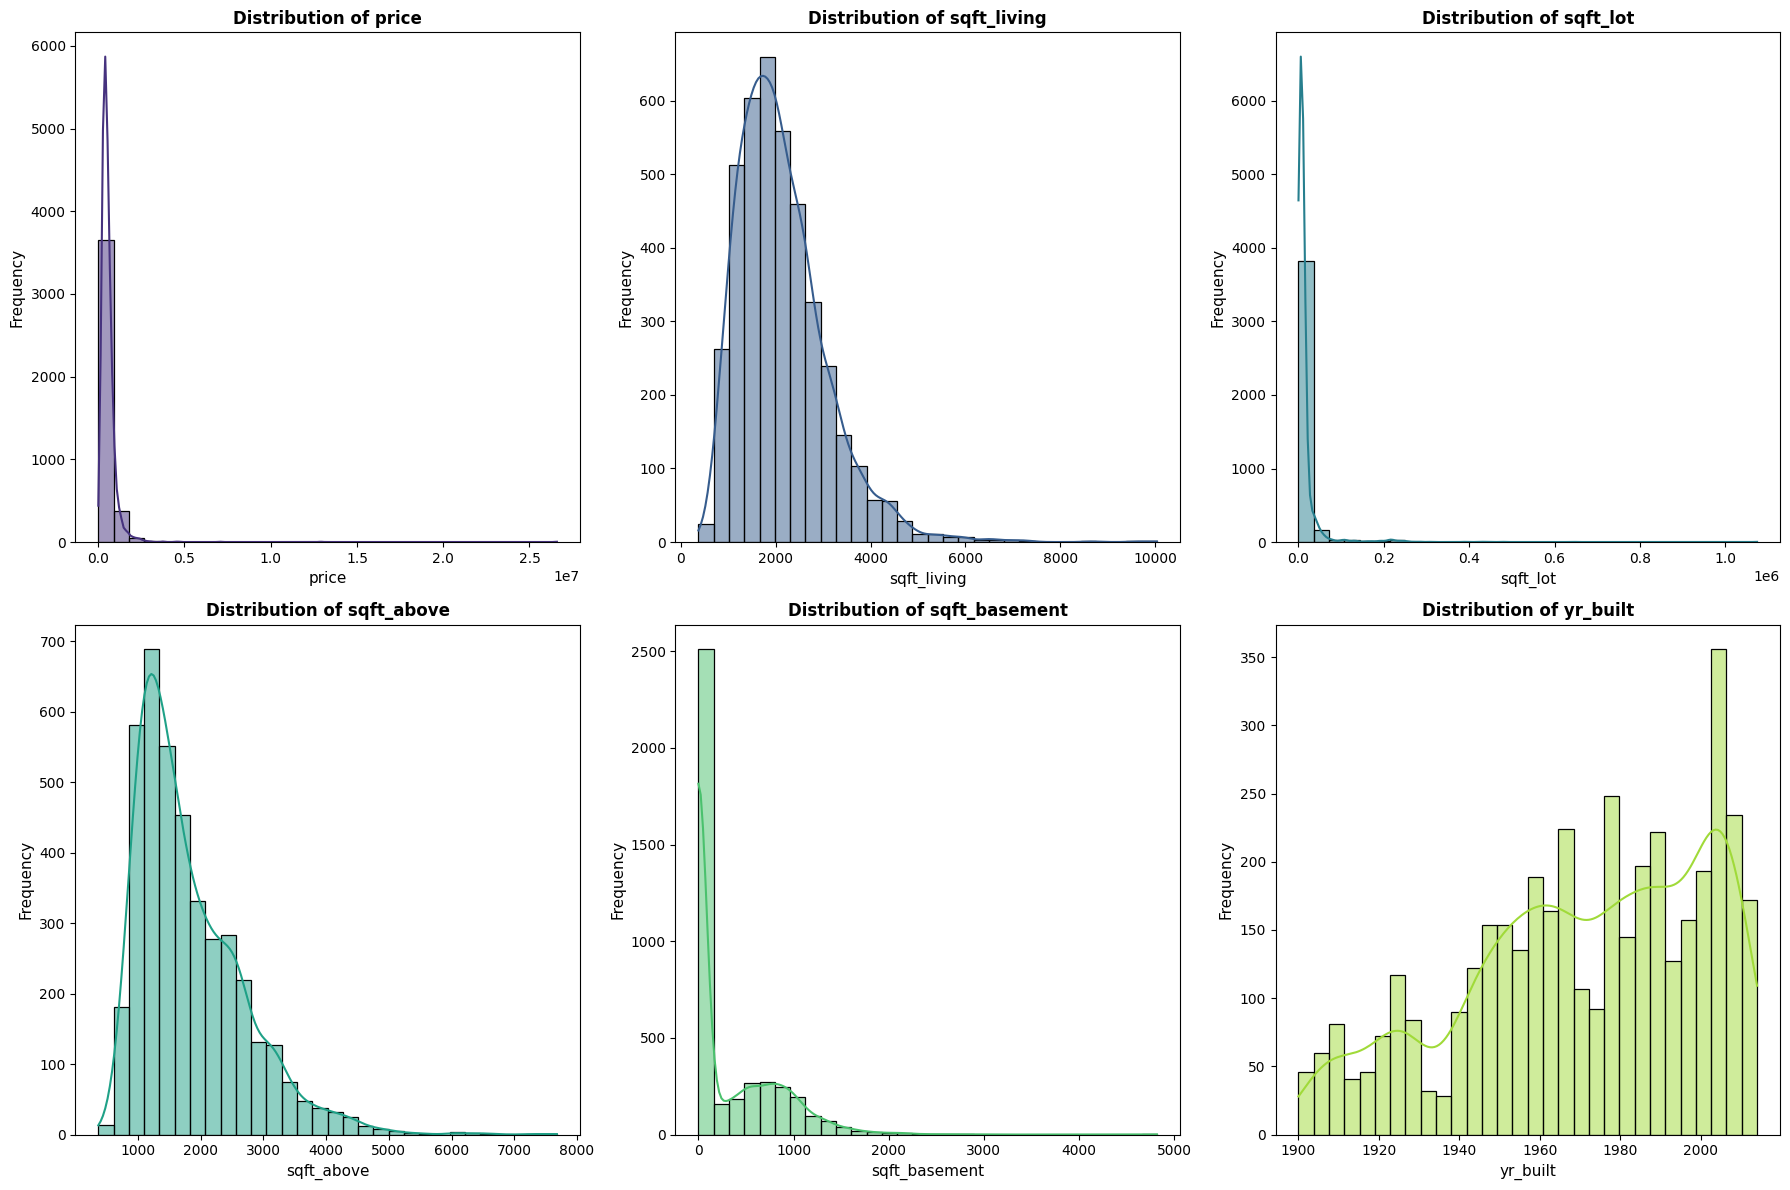

In [10]:
# Define key numerical features
features = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built']

# Adjust the grid layout dynamically based on the number of features
num_features = len(features)
rows = (num_features // 3) + (num_features % 3 > 0)
cols = 3


fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

# Create histograms for each feature
for i, feature in enumerate(features):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color=sns.color_palette("viridis")[i])
    axes[i].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


* Skewed Columns and Outliers

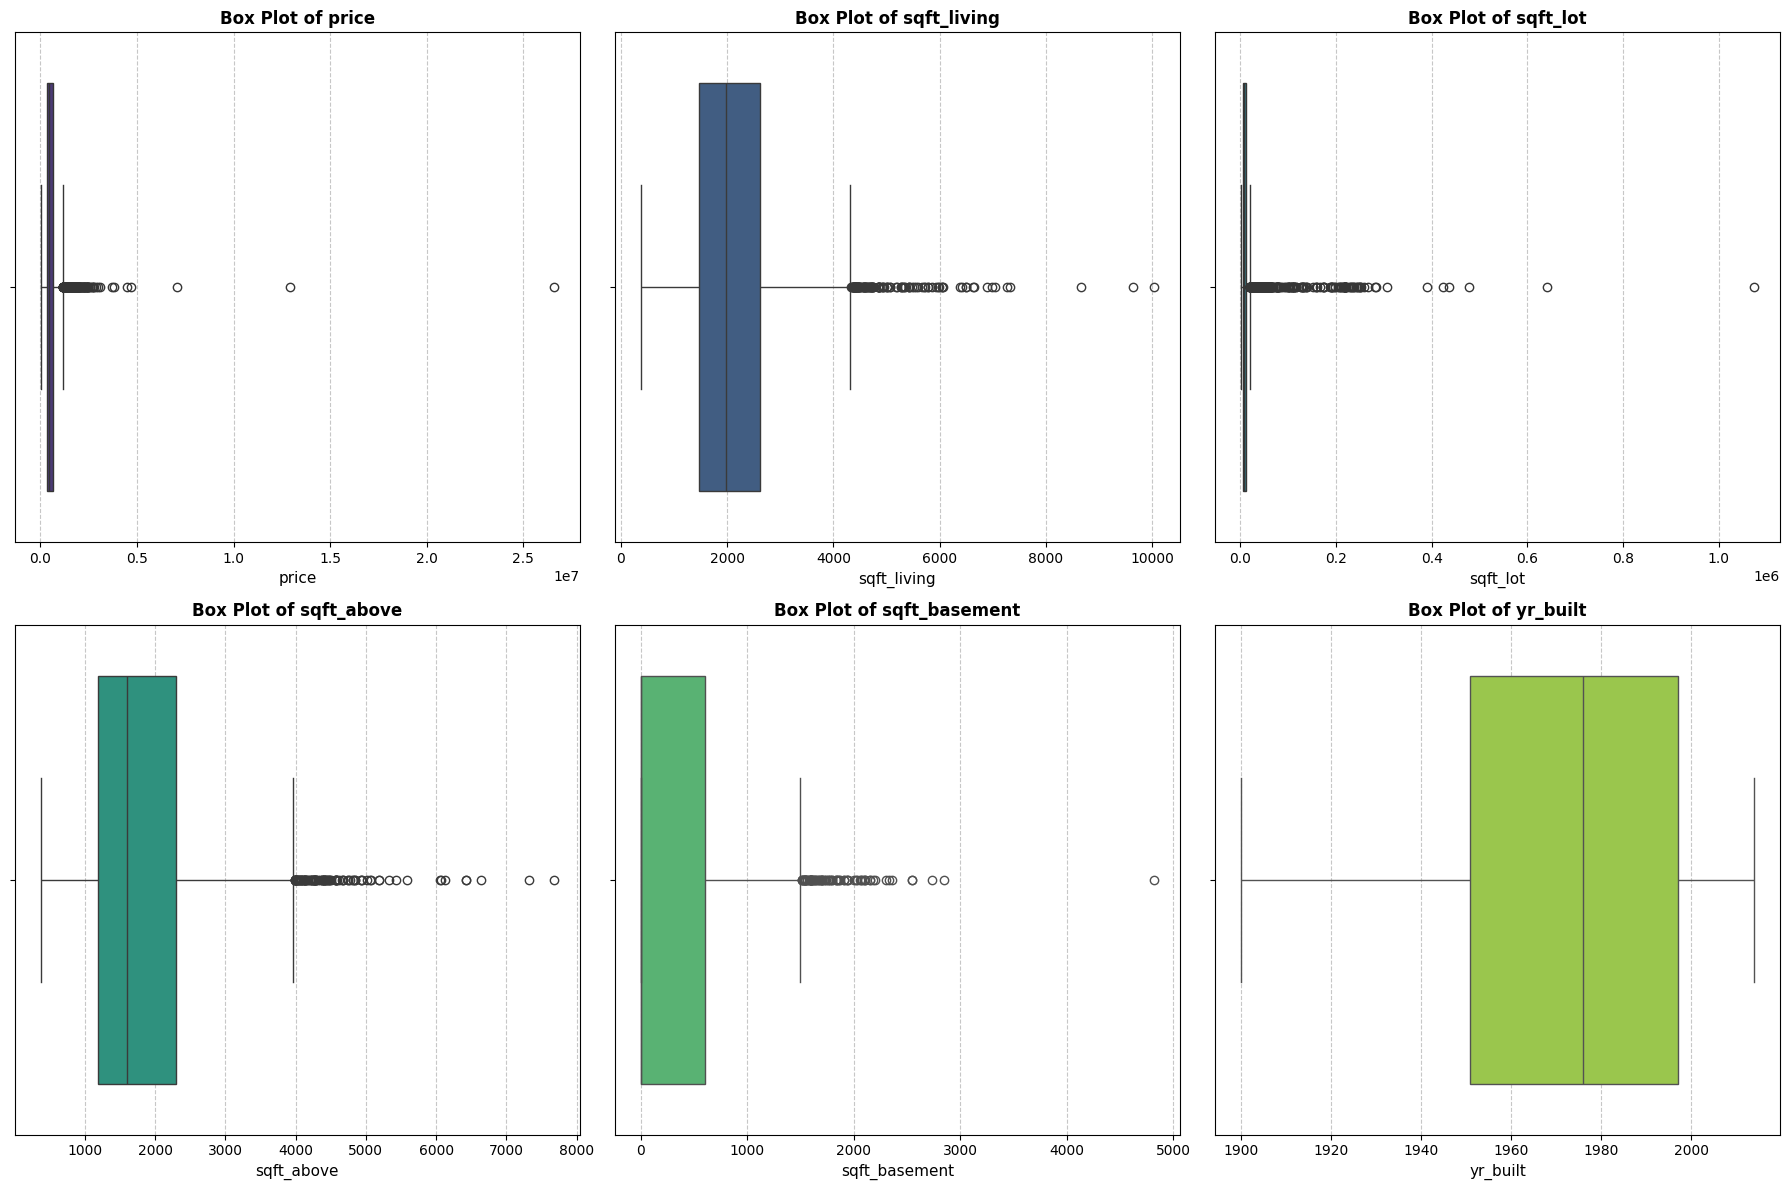

In [13]:
# Define key numerical features
features = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built']

# Determine rows and columns for subplot layout
num_features = len(features)
rows = (num_features // 3) + (num_features % 3 > 0)
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

# Create box plots for each feature
for i, feature in enumerate(features):
    sns.boxplot(x=df[feature], ax=axes[i], color=sns.color_palette("viridis")[i])
    axes[i].set_title(f'Box Plot of {feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=11)
    axes[i].grid(axis="x", linestyle="--", alpha=0.7)


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Outliers Detected in the Columns

The following columns contain significant outliers:

* price
* sqft_living
* sqft_lot
* sqft_above
* sqft_basement

* Removing Outliers Using the Interquartile Range (IQR)

In [14]:
# Columns for IQR filtering
columns_to_filter = ['price', 'sqft_living', 'sqft_lot', 'sqft_above','sqft_basement']

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.35)
        Q3 = df[col].quantile(0.85)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers_iqr(df, columns_to_filter)

print(df.shape)

(3604, 18)


# Univariate Analysis of Each Column After Removing Outliers

* Price Analysis

In [15]:
df["price"].value_counts().nlargest(10)

,count
price,
300000.0,39
400000.0,26
440000.0,25
250000.0,25
450000.0,24
350000.0,24
525000.0,24
435000.0,23
415000.0,22


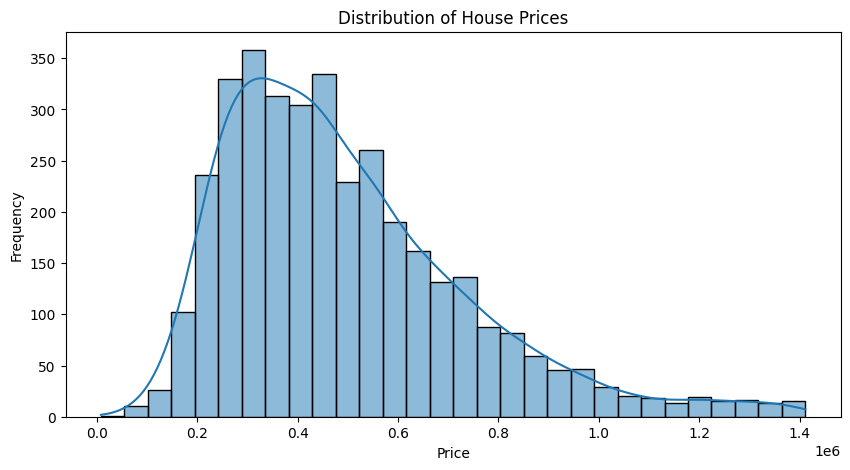

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=30, kde=True)  # KDE adds a smooth curve
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices")
plt.show()

In [17]:
print("Min Price: ", df['price'].min())
print("Median Price: ", df['price'].median())
print("Max Price: ", df['price'].max())
print("Mean Price: ", df['price'].mean())

Min Price:  7800.0
Median Price:  442500.0
Max Price:  1411600.0
Mean Price:  494704.7942892389


<ipython-input-18-e3b8ecd780e0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=common_prices.index, y=common_prices.values, palette="viridis")


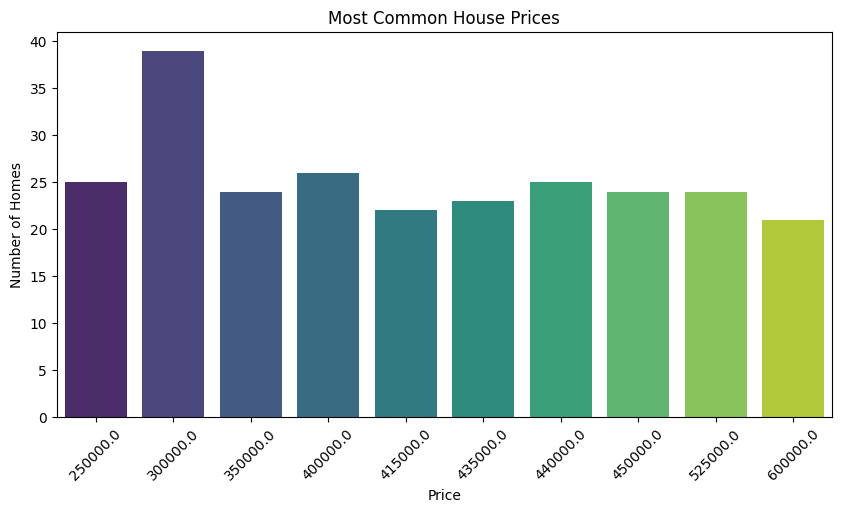

In [18]:
plt.figure(figsize=(10, 5))
common_prices = df['price'].value_counts().nlargest(10)  # Top 10 most common prices
sns.barplot(x=common_prices.index, y=common_prices.values, palette="viridis")
plt.xlabel("Price")
plt.ylabel("Number of Homes")
plt.title("Most Common House Prices")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

* Bathrooms and Bedrooms Analysis

In [19]:
df['bathrooms'].value_counts()

,count
bathrooms,
2.50,947
1.00,645
1.75,510
2.00,342
2.25,323
1.50,247
2.75,221
3.00,116
3.50,106


In [20]:
df['bedrooms'].value_counts()

,count
bedrooms,
3.0,1670
4.0,1145
2.0,470
5.0,242
6.0,38
1.0,33
7.0,5
8.0,1


Bedrooms
* Most homes have 3–4 bedrooms:
* 3 Bedrooms → 1670 entries
* 4 Bedrooms → 1145 entries

Bathrooms
* Peak at 2.5 bathrooms → 947 entries

Indicates mid-range homes

Sqft_Living Analysis

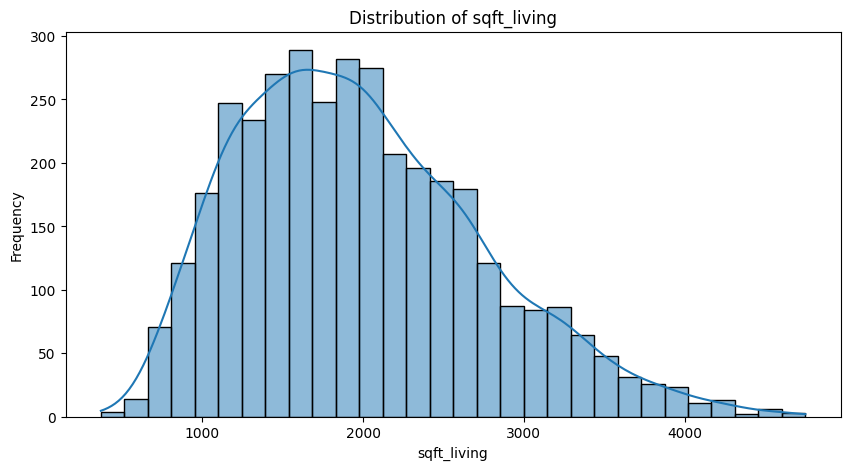

In [21]:
# Plot distribution of the 'price' column
plt.figure(figsize=(10, 5))
sns.histplot(df['sqft_living'], bins=30, kde=True)
plt.xlabel("sqft_living")
plt.ylabel("Frequency")
plt.title("Distribution of sqft_living")
plt.show()

Waterfront Analysis

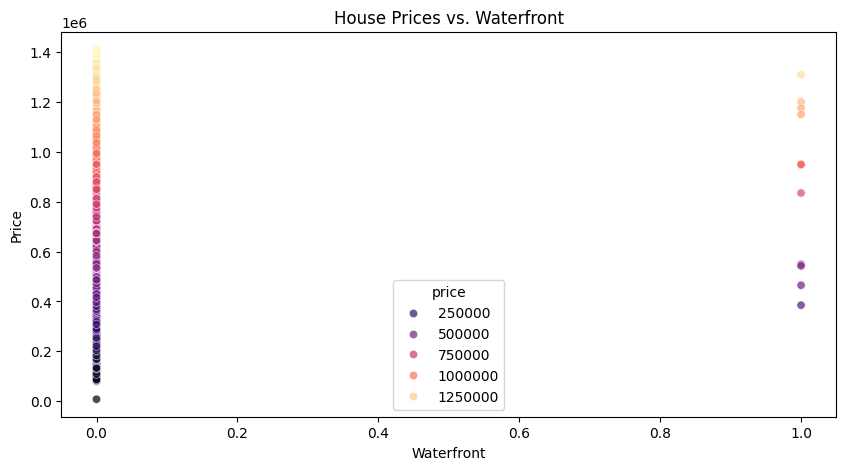

In [22]:
# Scatter plot for Waterfront vs. Price with Price as hue
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["waterfront"], y=df["price"], hue=df["price"], palette="magma", alpha=0.7)

plt.xlabel("Waterfront")
plt.ylabel("Price")
plt.title("House Prices vs. Waterfront")

plt.show()

* The waterfront feature has minimal impact on house prices. Although prices tend to increase for waterfront properties, there are only 11 such entries in the dataset.

* Due to the small sample size, this feature does not significantly influence model's predictions.

## View Analysis

In [23]:
df['view'].value_counts()

,count
view,
0,3318
2,142
3,66
1,46
4,32


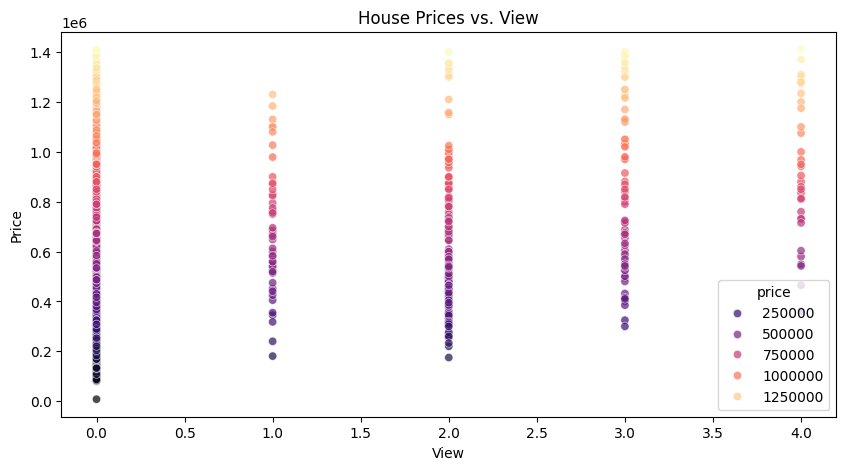

In [24]:
# Scatter plot for View vs. Price with Price as hue
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["view"], y=df["price"], hue=df["price"], palette="magma", alpha=0.7)

plt.xlabel("View")
plt.ylabel("Price")
plt.title("House Prices vs. View")

plt.show()

* The view rating significantly influences house prices. As the view score increases, both demand and property value tend to rise.

* Homes with higher view ratings generally have higher market value due to enhanced aesthetics and desirability.

## Yr_Built Analysis

In [25]:
df['yr_built'].value_counts().nlargest(10)

,count
yr_built,
2005,90
2006,87
2007,77
2004,75
2014,71
2008,71
2003,70
1967,70
1968,64


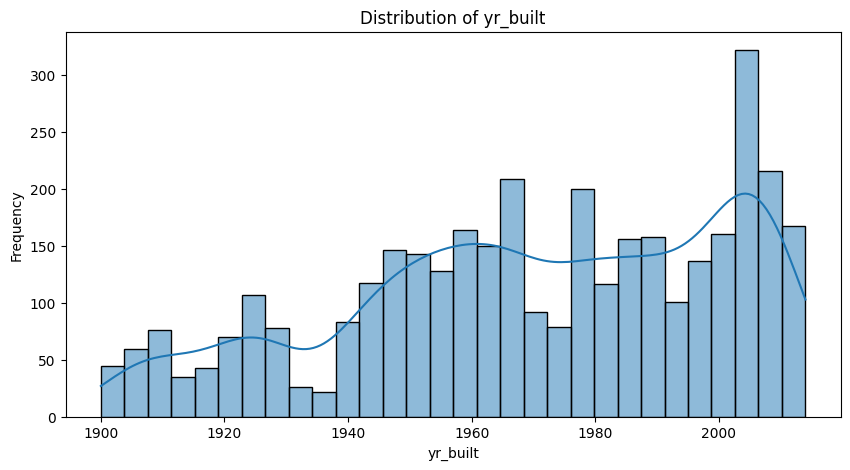

In [26]:
# Plot distribution of the 'yr_built' column
plt.figure(figsize=(10, 5))
sns.histplot(df['yr_built'], bins=30, kde=True)
plt.xlabel("yr_built")
plt.ylabel("Frequency")
plt.title("Distribution of yr_built")
plt.show()

## Address Columns

* street → This column does not provide meaningful information and will not impact model accuracy, so we will drop it.
* country → All entries are static (USA), making this column redundant. We will remove it to avoid unnecessary features.
* statezip → This column's relevance needs to be evaluated before deciding whether to retain or remove it.


Removing irrelevant columns helps in reducing noise and improving model efficiency, leading to better predictive performance.

In [27]:
df = df.drop(['street', 'country','statezip'], axis=1)

## City Analysis

In [28]:
df['city'].value_counts().nlargest(10)

,count
city,
Seattle,1353
Renton,240
Bellevue,206
Redmond,163
Kirkland,154
Kent,143
Sammamish,132
Auburn,131
Issaquah,128


<ipython-input-29-8c7ed9c4af54>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df1["City"], x=df1["Count"], palette="Blues_r")


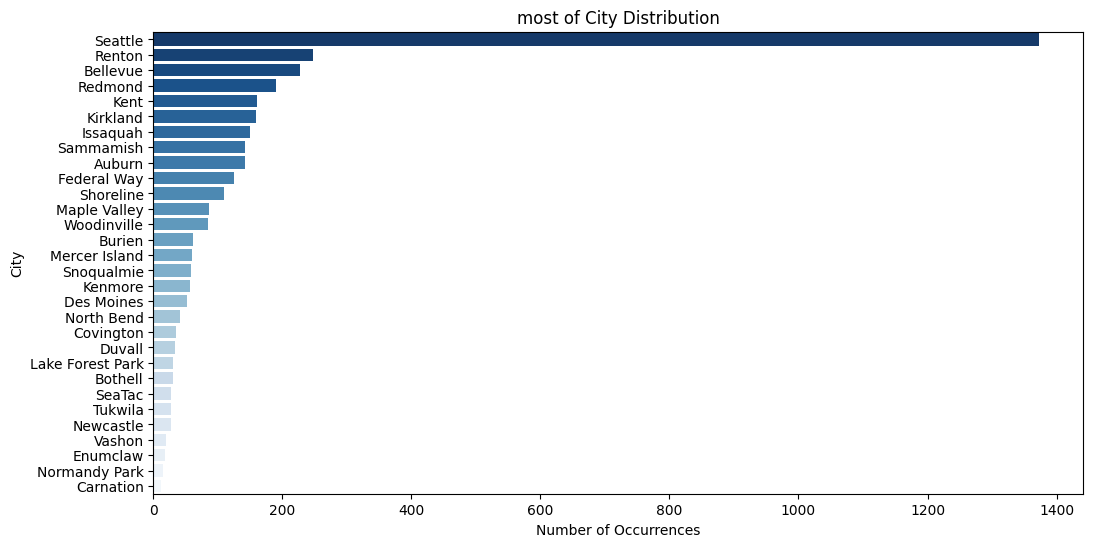

In [29]:
data = {
    "City": ["Seattle", "Renton", "Bellevue", "Redmond", "Kent", "Kirkland", "Issaquah", "Sammamish",
             "Auburn", "Federal Way", "Shoreline", "Maple Valley", "Woodinville", "Burien", "Mercer Island",
             "Snoqualmie", "Kenmore", "Des Moines", "North Bend", "Covington", "Duvall", "Lake Forest Park",
             "Bothell", "SeaTac", "Tukwila", "Newcastle", "Vashon", "Enumclaw", "Normandy Park", "Carnation"],
    "Count": [1373, 248, 227, 190, 160, 159, 149, 142, 142, 125, 110, 86, 84, 61, 60, 58, 57, 52, 41, 35,
              33, 31, 30, 28, 27, 27, 19, 18, 15, 12]
}

df1=pd.DataFrame(data)
df1=df1.sort_values(by="Count", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(y=df1["City"], x=df1["Count"], palette="Blues_r")
plt.xlabel("Number of Occurrences")
plt.ylabel("City")
plt.title("most of City Distribution")
plt.show()

Most of the houses in the dataset are located in Seattle. This indicates that the dataset primarily represents the Seattle housing market, which may influence trends in pricing, demand, and property characteristics.

# Feature Engineering

In [30]:
#make the date column into year and month
df['date'] = pd.to_datetime(df['date'])
df['year_sold']= df['date'].dt.year
df['month_sold'] = df['date'].dt.month

#remove the date column now
df = df.drop('date', axis=1)

Creating House Age, Renovation Age, and Price per Square Foot¶

Key Benefits:
* House Age helps in assessing depreciation and market trends.
* Renovation Age indicates the impact of renovations on pricing and condition.
* Price per Square Foot allows for better price comparisons across different home sizes.

In [31]:
df['house_age'] = 2014 - df['yr_built']
df['renovation_age'] = np.where(df['yr_renovated'] == 0, df['house_age'],  2014 - df['yr_renovated'])
df['price_per_sqft'] = df['price'] / df['sqft_living']

In [32]:
# remove year_sold since all recorded values are from 2014.
df = df.drop(['year_sold'],axis=1)

In [33]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,month_sold,house_age,renovation_age,price_per_sqft
0,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,Seattle,5,6,6,280.597015
3,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,Seattle,5,7,7,324.649299
4,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,Seattle,5,35,35,179.705882
5,320000.0,3.0,2.50,2130,6969,2.0,0,0,3,2130,0,2003,0,Maple Valley,5,11,11,150.234742
6,875000.0,4.0,2.00,2520,6000,1.0,0,0,3,1400,1120,1921,2007,Seattle,5,93,7,347.222222


# Further Analysis After Feature Engineering

* Price vs. Bedrooms / Bathrooms

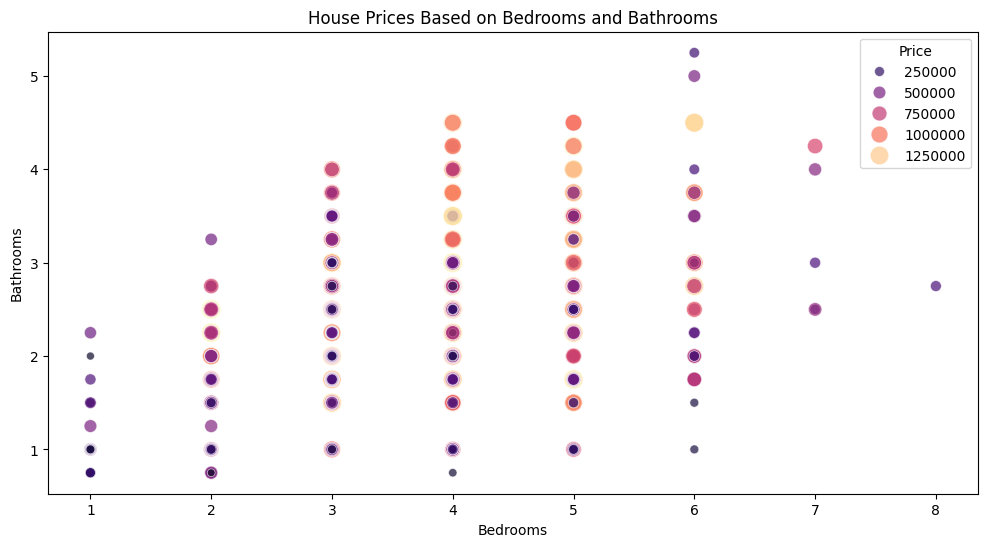

In [34]:
# Scatter plot for Bedrooms vs. Bathrooms with Price encoding
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=df["bedrooms"],
    y=df["bathrooms"],
    size=df["price"],
    hue=df["price"],
    sizes=(20, 200),
    palette="magma",
    alpha=0.7
)


plt.xlabel("Bedrooms")
plt.ylabel("Bathrooms")
plt.title("House Prices Based on Bedrooms and Bathrooms")
plt.legend(title="Price", loc="best")

plt.show()

Trend Analysis:
* As the number of bedrooms increases, the number of bathrooms also tends to increase.
* Properties with more bedrooms and bathrooms tend to have higher prices.

 ### Relationship Between Price and Living Area

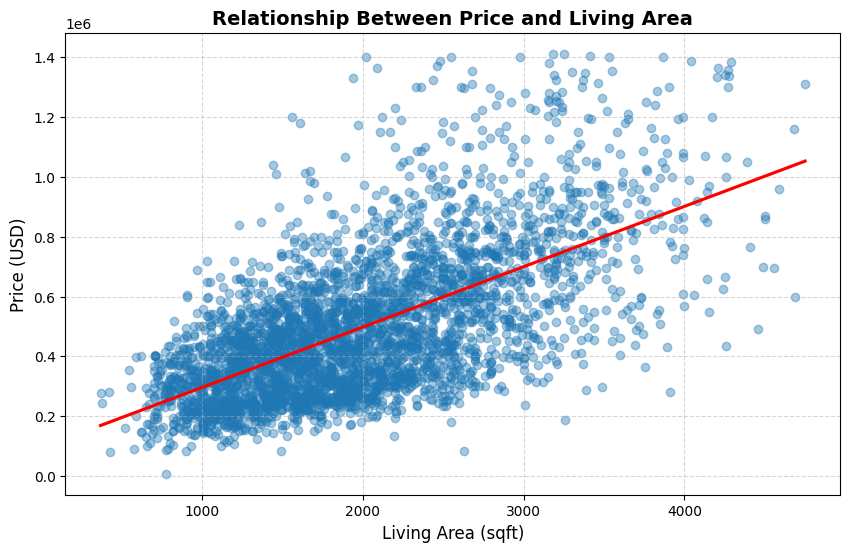

In [35]:
plt.figure(figsize=(10, 6))

# Scatter plot with a regression line
sns.regplot(x=df['sqft_living'], y=df['price'], scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'}, ci=None)

plt.xlabel('Living Area (sqft)', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.title('Relationship Between Price and Living Area', fontsize=14, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

The plot likely shows a positive trend: as living area (sqft) increases, price (USD) also rises. This aligns with real estate fundamentals where larger homes generally command higher prices.

### Top 10 Cities by Price per Sqft
Analyzing price per square foot helps identify premium and affordable markets.

* Max Price per Sqft → Luxury areas with high demand.
* Min Price per Sqft → Budget-friendly housing markets.
* Avg Price per Sqft → Reflects overall market trends.

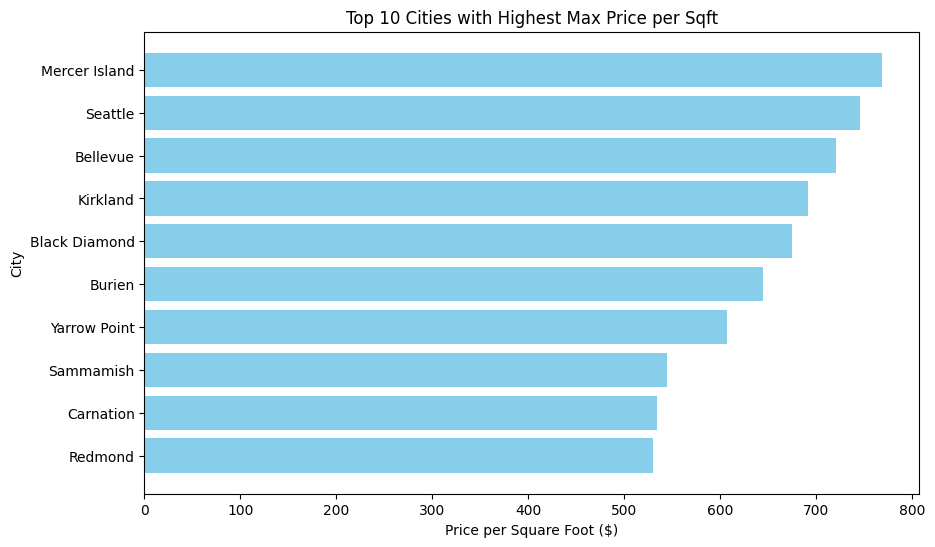

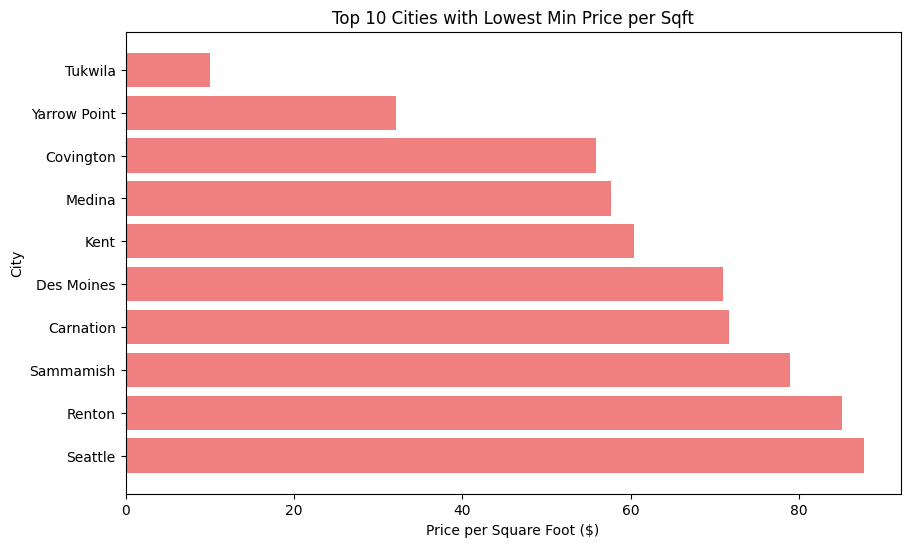

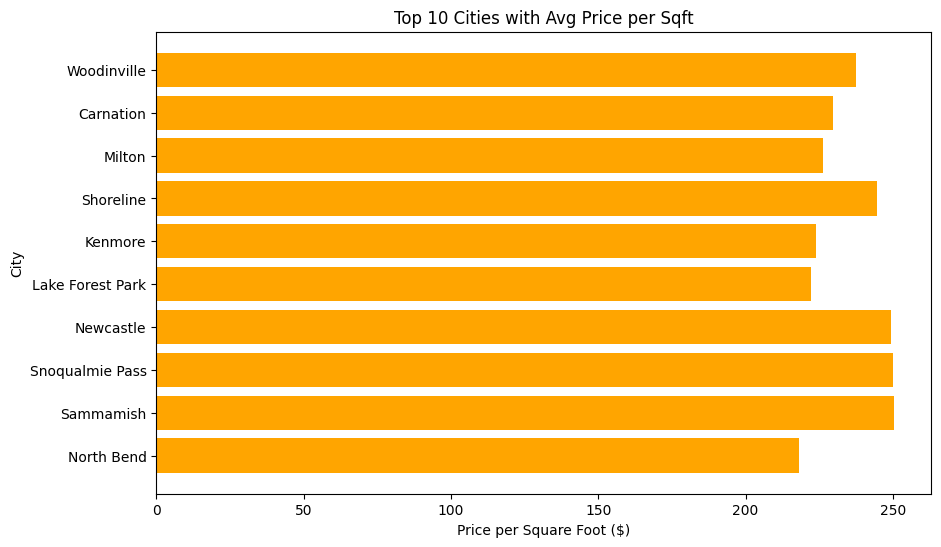

In [36]:
# Group by city and calculate min, max, and average price per sqft
df_stats = df.groupby('city', as_index=False).agg(
    min_price_per_sqft=('price_per_sqft', 'min'),
    max_price_per_sqft=('price_per_sqft', 'max'),
    avg_price_per_sqft=('price_per_sqft', 'mean')
)

# Get top 10 cities for max, min, and average price per sqft
top_max_cities = df_stats.nlargest(10, 'max_price_per_sqft')
top_min_cities = df_stats.nsmallest(10, 'min_price_per_sqft')
top_avg_cities = df_stats.iloc[(df_stats['avg_price_per_sqft'] - df_stats['avg_price_per_sqft'].mean()).abs().argsort()[:10]]

# Function to plot top 10 cities
def plot_top_cities(df, column, title, color):
    plt.figure(figsize=(10, 6))
    plt.barh(df['city'], df[column], color=color)
    plt.xlabel('Price per Square Foot ($)')
    plt.ylabel('City')
    plt.title(title)
    plt.gca().invert_yaxis()  # Show highest value at the top
    plt.show()

# Plot each case
plot_top_cities(top_max_cities, 'max_price_per_sqft', 'Top 10 Cities with Highest Max Price per Sqft', 'skyblue')
plot_top_cities(top_min_cities, 'min_price_per_sqft', 'Top 10 Cities with Lowest Min Price per Sqft', 'lightcoral')
plot_top_cities(top_avg_cities, 'avg_price_per_sqft', 'Top 10 Cities with Avg Price per Sqft', 'orange')

### The relationship between Sale Price and three different factors:
1. Year Built (yr_built)
2. Month Sold (month_sold)
3. Age of Home (ageofhome)

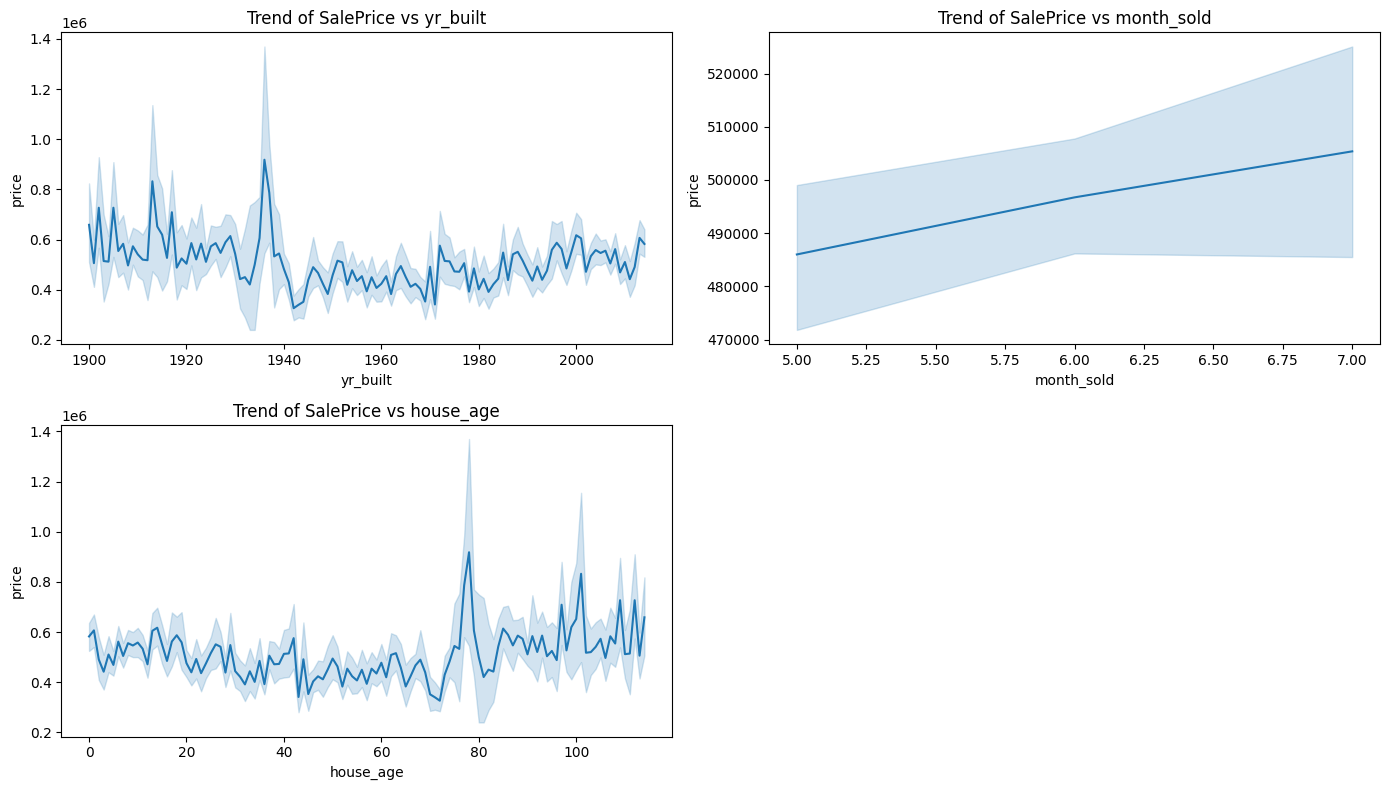

In [37]:
# List of columns to create trend lines for
columns = ['yr_built','month_sold','house_age']

# Create a plot for each column
plt.figure(figsize=(14, 8))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.lineplot(x=column, y='price', data=df)
    plt.title(f'Trend of SalePrice vs {column}')

plt.tight_layout()
plt.show()

1. Homes built around the 1940s and those around 80 years old tend to have price spikes, likely due to historical value.
2. Homes sold in the summer months (June-July) are generally priced higher, likely due to increased demand.
3. Newer homes (0-40 years old) have more predictable and stable pricing trends.

#### Histplot of Price by Condition

<ipython-input-38-ddc0b96336d8>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x='condition', y='price', data=df, palette='coolwarm')


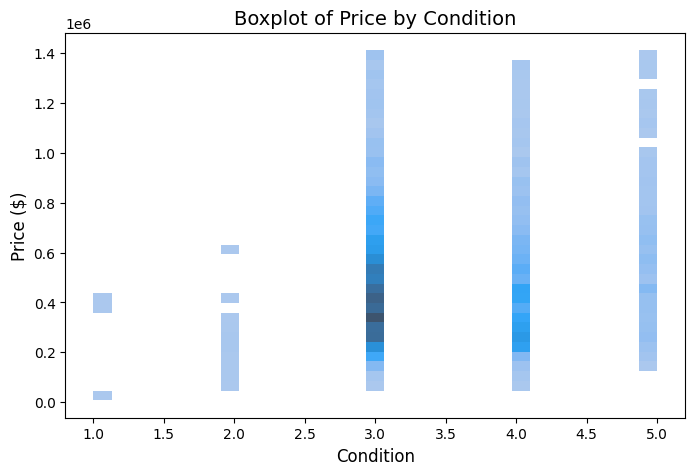

In [38]:
plt.figure(figsize=(8, 5))

# Create the boxplot
sns.histplot(x='condition', y='price', data=df, palette='coolwarm')

plt.xlabel("Condition", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.title("Boxplot of Price by Condition", fontsize=14)

plt.show()

Overall Takeaways:
* Homes in better condition (4 & 5) attract higher prices and have more variability in pricing.
* Houses in poor condition (1 & 2) remain in lower price brackets with limited variation.
* Renovations or home improvements could significantly increase a home's value, as seen in the pricing differences across conditions.

## Average Home Prices by Renovation Year

In [39]:
import plotly.express as px
# Exclude non-renovated homes
df_renovated = df[df["yr_renovated"] > 0]

# Group by renovation year and compute mean price
df_renovated = df_renovated.groupby("yr_renovated")["price"].mean().reset_index()

# Sort and take the top 10
df_renovated = df_renovated.sort_values(by="price", ascending=False)

# Create bar chart
fig = px.bar(df_renovated, x="yr_renovated", y="price",
             title="Average Home Prices by Renovation Year",
             labels={"yr_renovated": "Year Renovated", "price": "Average Price"},
             text_auto=True)

fig.show()

1. Recent Renovations Tend to Have Higher Prices
* Homes renovated after 2000 generally have higher average prices compared to older renovations.
* This suggests that modern upgrades increase home value, making newer renovations more desirable.

2. Price Peaks in Certain Years

* A significant price spike is visible around the early 2000s and another near the 1960s and 1980s.
* This could indicate that major renovation trends occurred in those years, possibly due to new building codes, housing market booms, or major economic events affecting home upgrades.

3. Older Renovations Still Hold Value

* Some homes renovated before 1950 still show high average prices, suggesting that historic or well-maintained homes remain valuable in the market.

4. Price Variability Across Years

* The fluctuations in price suggest that not all renovations lead to the same value increase.
* The quality, extent, and location of the renovation likely play a big role in determining price impact.

#### Renovation Status of Houses¶
* 0 → Never Renovated
* 1 → Renovated

* Nearly half of the houses have never been renovated, suggesting that renovation status may influence pricing and demand.

In [40]:
# Convert yr_renovated to 'Never Renovated' or 'Renovated'
df['renovation_status'] = df['yr_renovated'].apply(lambda x: 'Never_Renovated' if x == 0 else 'Renovated')
#also remove yr_renovated column
df = df.drop('yr_renovated', axis=1)

In [41]:
# Convert sqft_basement to 'Has Basement' or 'No Basement'
df['basement_status'] = df['sqft_basement'].apply(lambda x: 'No_Basement' if x == 0 else 'Has_Basement')
#also remove the sqft_basement after
df = df.drop('sqft_basement', axis=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,yr_built,city,month_sold,house_age,renovation_age,price_per_sqft,renovation_status,basement_status
0,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,2008,Seattle,5,6,6,280.597015,Never_Renovated,No_Basement
3,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,2007,Seattle,5,7,7,324.649299,Never_Renovated,Has_Basement
4,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1979,Seattle,5,35,35,179.705882,Never_Renovated,Has_Basement
5,320000.0,3.0,2.50,2130,6969,2.0,0,0,3,2130,2003,Maple Valley,5,11,11,150.234742,Never_Renovated,No_Basement
6,875000.0,4.0,2.00,2520,6000,1.0,0,0,3,1400,1921,Seattle,5,93,7,347.222222,Renovated,Has_Basement


In [42]:
#savethe cleaned df
df.to_csv('cleaned_data.csv', index=False)

# Model Building

In [43]:
df=pd.read_csv('cleaned_data.csv')
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'yr_built', 'city',
       'month_sold', 'house_age', 'renovation_age', 'price_per_sqft',
       'renovation_status', 'basement_status'],
      dtype='object')

In [44]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,yr_built,city,month_sold,house_age,renovation_age,price_per_sqft,renovation_status,basement_status
0,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,2008,Seattle,5,6,6,280.597015,Never_Renovated,No_Basement
1,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,2007,Seattle,5,7,7,324.649299,Never_Renovated,Has_Basement
2,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1979,Seattle,5,35,35,179.705882,Never_Renovated,Has_Basement
3,320000.0,3.0,2.50,2130,6969,2.0,0,0,3,2130,2003,Maple Valley,5,11,11,150.234742,Never_Renovated,No_Basement
4,875000.0,4.0,2.00,2520,6000,1.0,0,0,3,1400,1921,Seattle,5,93,7,347.222222,Renovated,Has_Basement


* Removing the Irrelevant Columns: 'house_age', 'month_sold'

In [45]:
# removing the un usefeul columns yr_built month_sold basement_category
df = df.drop(['house_age', 'month_sold'], axis=1)

In [46]:
# Define features and target
X = df.drop(columns=['price'])
y = df['price']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

In [47]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [48]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
#Model Training (Linear Regression)
linear_regression_model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])
linear_regression_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'yr_built',
       'renovation_age', 'price_per_sqft'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['city', 'renovation_status', 'basement_status'], dtype='object'))])),
                ('model', LinearRegression())])

In [50]:
# Model Training (Random Forest)
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', rf_model)
    ])

param_grid = {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [5, 10, 15],
        'model__min_samples_split': [2, 4, 6]
    }


grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")



Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'model__max_depth': 15, 'model__min_samples_split': 2, 'model__n_estimators': 150}


In [51]:
 # Model Training (XGBoost)
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb_model)
    ])
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'yr_built',
       'renovation_age', 'price_per_sqft'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['city', 'renovation_status', 'basement_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

# Model Evaluation

In [52]:
def evaluate(model, name):
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  print(f"\n{name} Results:")
  print(f"RMSE: {rmse:.3f}")
  print(f"R²: {r2:.3f}")
  print(f"MAE: {mae:.3f}")
  return y_pred

# Evaluate Models
_ = evaluate(linear_regression_model, "Linear Regression")
_ = evaluate(grid_search, "Random Forest")
_ = evaluate(xgb_pipeline, "XGBoost Results")


Linear Regression Results:
RMSE: 64996.524
R²: 0.922
MAE: 43211.740

Random Forest Results:
RMSE: 14750.388
R²: 0.996
MAE: 6639.686

XGBoost Results Results:
RMSE: 17843.393
R²: 0.994
MAE: 10502.448


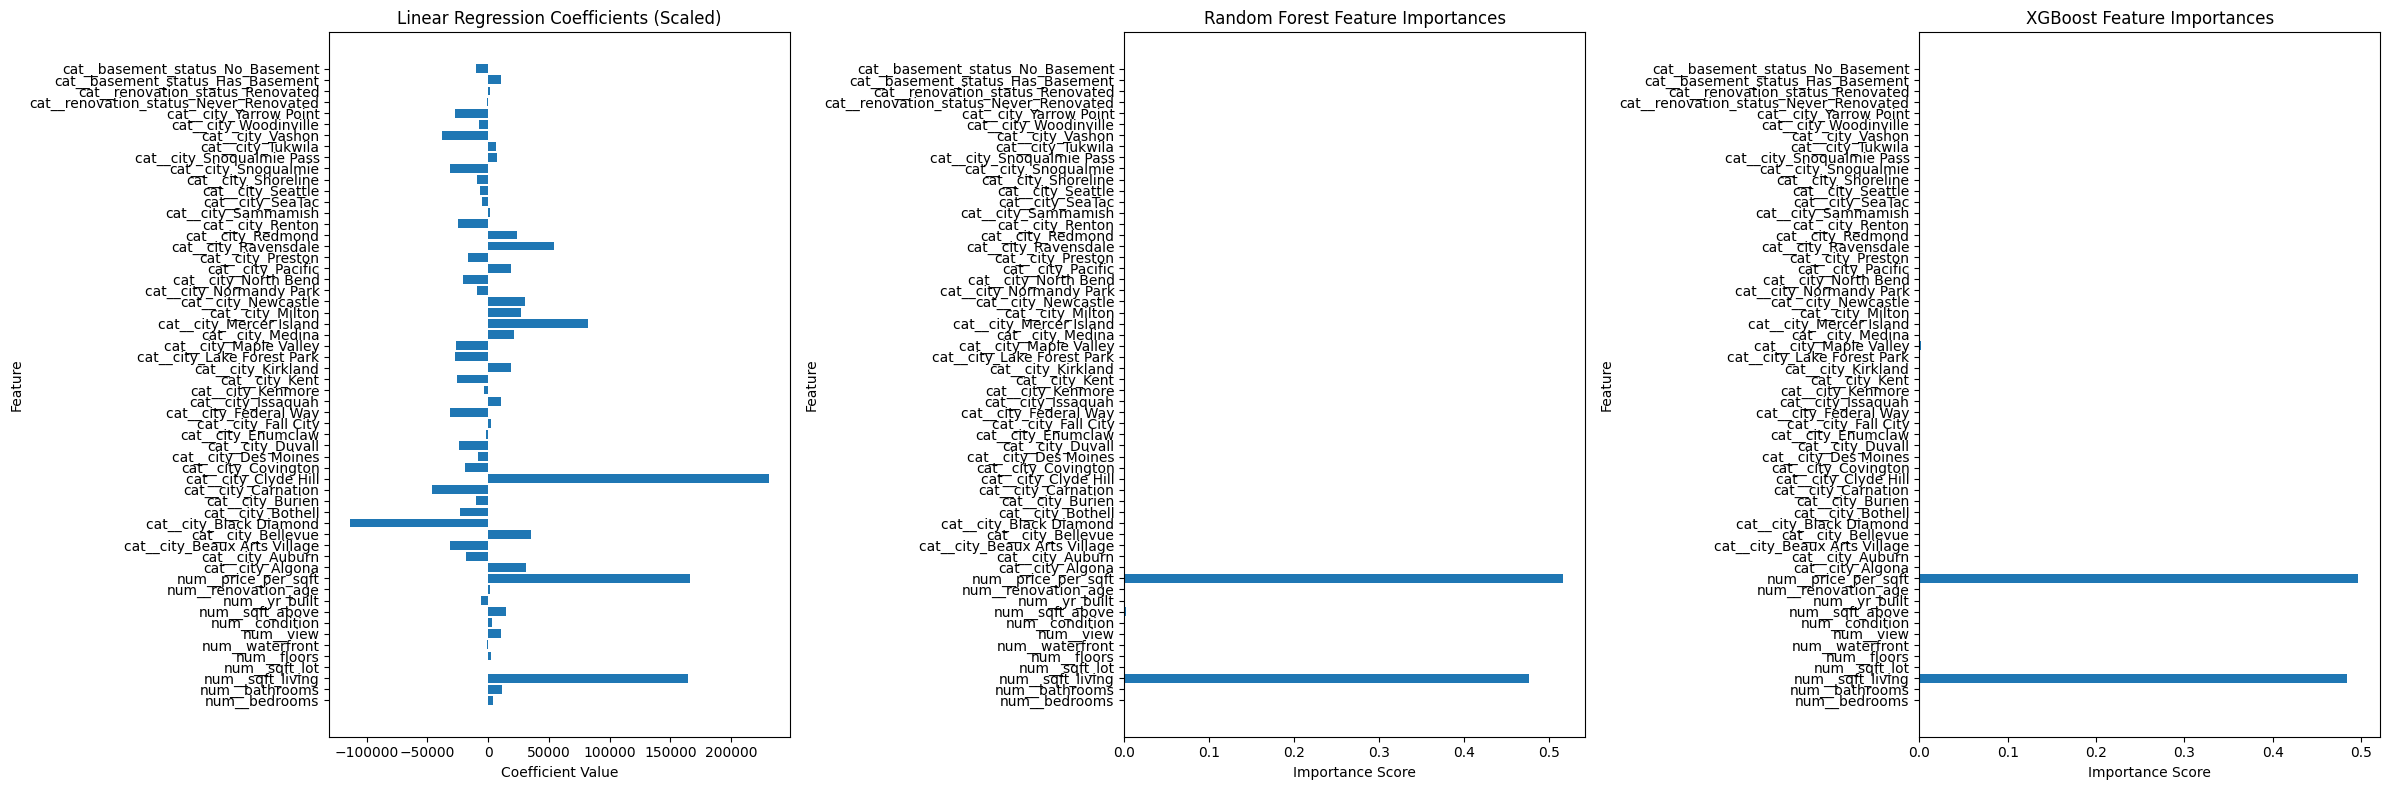

In [53]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
axes = axes.ravel()

# 1. Ridge Regression Coefficients (Scaled)
ridge_coefs = linear_regression_model.named_steps['model'].coef_
# Get feature names after one-hot encoding
feature_names = linear_regression_model[:-1].get_feature_names_out()
axes[0].barh(feature_names, ridge_coefs)
axes[0].set_title("Linear Regression Coefficients (Scaled)")
axes[0].set_xlabel("Coefficient Value")
axes[0].set_ylabel("Feature")

# 2. Random Forest Feature Importances
rf_importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
# Use the same feature names as for Linear Regression
axes[1].barh(feature_names, rf_importances)
axes[1].set_title("Random Forest Feature Importances")
axes[1].set_xlabel("Importance Score")
axes[1].set_ylabel("Feature")

# 3. XGBoost Feature Importances
xgb_importances = xgb_pipeline.named_steps['model'].feature_importances_
# Use the same feature names as for Linear Regression
axes[2].barh(feature_names, xgb_importances)
axes[2].set_title("XGBoost Feature Importances")
axes[2].set_xlabel("Importance Score")
axes[2].set_ylabel("Feature")

plt.tight_layout()
plt.show()